# Music ROI Summary
Create ROI-level summaries for music (mean z per atlas region, per subject) and export them as
CSV tables.

In [1]:
# Cell 3 – paths and subject list

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import image, masking, plotting, datasets

# --- project paths ---
PROJECT_ROOT = Path(".")
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "music"
FIRSTLEVEL_ROOT = DERIV_ROOT / "firstlevel"

# subjects used in music project (run-02)
MUSIC_SUBJECTS = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

print("DERIV_ROOT   :", DERIV_ROOT)
print("FIRSTLEVEL_ROOT:", FIRSTLEVEL_ROOT)
print("Subjects     :", MUSIC_SUBJECTS)

DERIV_ROOT   : derivatives\music
FIRSTLEVEL_ROOT: derivatives\music\firstlevel
Subjects     : ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005']


In [2]:
# Cell 4 – list scene/contrast z-maps and set up atlas choice

# z-maps we expect from Phase 4
for sub in MUSIC_SUBJECTS:
    z_path = FIRSTLEVEL_ROOT / f"{sub}_run-02_music_zmap.nii.gz"
    print(f"{sub}: {z_path}  (exists: {z_path.exists()})")

# We'll use Harvard–Oxford cortical atlas via Nilearn
atlas_ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img_path = atlas_ho.maps
atlas_labels   = list(atlas_ho.labels)

print("\nAtlas image:", atlas_img_path)
print("Number of atlas labels:", len(atlas_labels))
print("First 10 labels:", atlas_labels[:10])

# Load atlas image
atlas_img = image.load_img(atlas_img_path)
atlas_data = atlas_img.get_fdata().astype(int)

sub-001: derivatives\music\firstlevel\sub-001_run-02_music_zmap.nii.gz  (exists: True)
sub-002: derivatives\music\firstlevel\sub-002_run-02_music_zmap.nii.gz  (exists: True)
sub-003: derivatives\music\firstlevel\sub-003_run-02_music_zmap.nii.gz  (exists: True)
sub-004: derivatives\music\firstlevel\sub-004_run-02_music_zmap.nii.gz  (exists: True)
sub-005: derivatives\music\firstlevel\sub-005_run-02_music_zmap.nii.gz  (exists: True)


[fetch_atlas_harvard_oxford] Dataset found in C:\Users\Nirwaan Azhar\nilearn_data\fsl


Atlas image: 
<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine:
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 48.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL3.3'
aux_file        : b'MGH-Cortical'
qform_code      :

In [3]:
# Cell 5 – build ROI index/name table (skip background)

roi_indices = []
roi_names = []
for idx, name in enumerate(atlas_labels):
    if idx == 0:
        continue
    roi_indices.append(idx)
    roi_names.append(name)

roi_table = pd.DataFrame({"roi_index": roi_indices, "roi_name": roi_names})
print("Number of ROIs (excluding background):", len(roi_indices))
roi_table.head(10)

Number of ROIs (excluding background): 48


,roi_index,roi_name
0,1,Frontal Pole
1,2,Insular Cortex
2,3,Superior Frontal Gyrus
3,4,Middle Frontal Gyrus
4,5,"Inferior Frontal Gyrus, pars triangularis"
5,6,"Inferior Frontal Gyrus, pars opercularis"
6,7,Precentral Gyrus
7,8,Temporal Pole
8,9,"Superior Temporal Gyrus, anterior division"
9,10,"Superior Temporal Gyrus, posterior division"


In [4]:
# Cell 6 – helper function: ROI means for one subject z-map

def extract_roi_means(z_map_img, atlas_img, roi_indices, roi_names):
    """
    Compute mean z-score in each ROI for a given z-map.
    Returns a pandas Series with index = roi_names.
    """
    atlas_resampled = image.resample_to_img(
        atlas_img, z_map_img, 
        interpolation="nearest",
        force_resample=True,
        copy_header=True
    )
    atlas_resampled_data = atlas_resampled.get_fdata().astype(int)
    z_data = z_map_img.get_fdata()

    roi_means = []
    for idx in roi_indices:
        mask = atlas_resampled_data == idx
        if not np.any(mask):
            roi_means.append(np.nan)
            continue
        vals = z_data[mask]
        vals = vals[np.isfinite(vals)]
        roi_means.append(vals.mean() if vals.size > 0 else np.nan)

    return pd.Series(roi_means, index=roi_names)

In [5]:
# Cell 7 – loop over subjects and build wide + long ROI tables

all_roi_rows = []
long_rows = []

for sub in MUSIC_SUBJECTS:
    z_path = FIRSTLEVEL_ROOT / f"{sub}_run-02_music_zmap.nii.gz"
    if not z_path.exists():
        print(f"[WARN] Missing z-map for {sub}: {z_path}")
        continue

    z_img = image.load_img(z_path)
    roi_series = extract_roi_means(z_img, atlas_img, roi_indices=roi_indices, roi_names=roi_names)

    # wide row
    row_dict = {"subject": sub}
    row_dict.update(roi_series.to_dict())
    all_roi_rows.append(row_dict)

    # long rows
    for roi_name, val in roi_series.items():
        long_rows.append({"subject": sub, "ROI": roi_name, "mean_z": val})

# wide format
music_roi_wide = pd.DataFrame(all_roi_rows).set_index("subject")
print("Wide ROI table shape:", music_roi_wide.shape)

# long format
music_roi_long = pd.DataFrame(long_rows)
print("Long ROI table shape:", music_roi_long.shape)

# display small snippets
music_roi_wide.head(), music_roi_long.head()

Wide ROI table shape: (5, 48)
Long ROI table shape: (240, 3)


(         Frontal Pole  Insular Cortex  Superior Frontal Gyrus  \
 subject                                                         
 sub-001     -0.019928       -0.068484                0.002456   
 sub-002      0.036785        0.018796               -0.351147   
 sub-003      0.044747        0.009125                0.032207   
 sub-004     -0.058141       -0.141247               -0.088970   
 sub-005     -0.036446        0.108955               -0.744504   
 
          Middle Frontal Gyrus  Inferior Frontal Gyrus, pars triangularis  \
 subject                                                                    
 sub-001              0.001332                                   0.021281   
 sub-002             -0.045623                                  -0.090686   
 sub-003              0.028076                                   0.254245   
 sub-004             -0.043986                                  -0.295576   
 sub-005             -0.338398                                   0.175711 

In [6]:
# Cell 8 – save ROI tables to disk

ROI_ROOT = DERIV_ROOT / "roi"
ROI_ROOT.mkdir(parents=True, exist_ok=True)

wide_path = ROI_ROOT / "music_roi_means_wide.csv"
long_path = ROI_ROOT / "music_roi_means_long.csv"

music_roi_wide.to_csv(wide_path)
music_roi_long.to_csv(long_path, index=False)

print("Saved wide ROI table to :", wide_path)
print("Saved long ROI table to :", long_path)

Saved wide ROI table to : derivatives\music\roi\music_roi_means_wide.csv
Saved long ROI table to : derivatives\music\roi\music_roi_means_long.csv


Top 10 ROIs by group mean z:


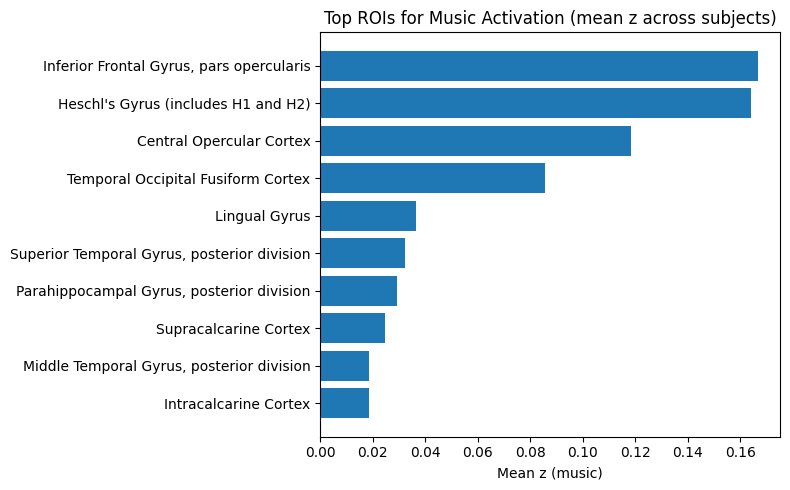

In [7]:
# Cell 9 – group mean per ROI + barplot of top ROIs

# group mean across subjects (ignoring NaNs)
group_mean_roi = music_roi_wide.mean(axis=0)

group_mean_df = (
    group_mean_roi
    .rename("group_mean_z")
    .reset_index()
    .rename(columns={"index": "ROI"})
    .sort_values("group_mean_z", ascending=False)
)

print("Top 10 ROIs by group mean z:")
group_mean_df.head(10)

# Barplot of top 10 ROIs
top_n = 10
top_df = group_mean_df.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_df["ROI"], top_df["group_mean_z"])
plt.gca().invert_yaxis()   # largest on top
plt.xlabel("Mean z (music)")
plt.title("Top ROIs for Music Activation (mean z across subjects)")
plt.tight_layout()
plt.show()